In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_auc_score
import joblib

In [13]:
from google.colab import drive
drive.mount('/content/drive')
provider_df = pd.read_csv('/content/drive/MyDrive/provider_features.csv')

X = provider_df.drop(columns=["Provider","target"])
y = provider_df["target"]
provider_df.shape
provider_df['target'].value_counts()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,count
target,
0,4904
1,506


In [14]:
drive_path = '/content/drive/MyDrive/trained_models/'
scaler = joblib.load(drive_path + 'scaler.joblib')
model_files = {
"Decision Tree": drive_path + 'decision_tree_model.joblib',
"Random Forest": drive_path + 'random_forest_model.joblib',
"Gradient Boosting": drive_path + 'gradient_boosting_model.joblib',
"SVM": drive_path + 'svm_model.joblib'
}

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:57:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== Classification Report ===
Precision 0.5964912280701754
Recall 0.6732673267326733
F1-score 0.6325581395348837
=== Confusion Matrix ===
[[935  46]
 [ 33  68]]
PRAUC: 0.7200
ROC AUC: 0.9450


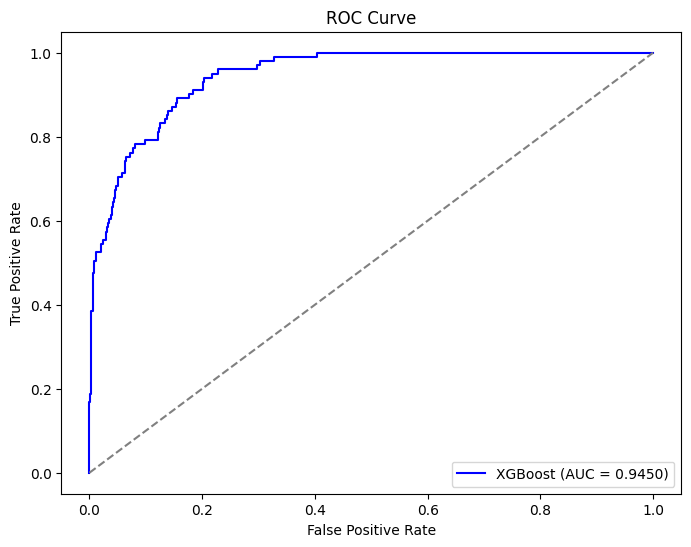

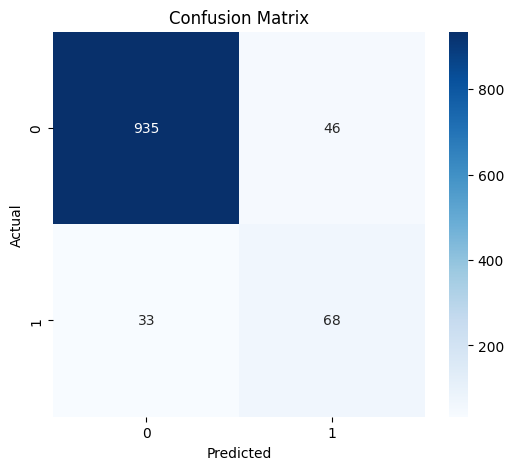

In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc,
    roc_curve,
    roc_auc_score,
    precision_score,  # Added import
    recall_score,     # Added import
    f1_score          # Added import
)
import matplotlib.pyplot as plt
import numpy as np

# X and y are already defined from provider_df in a previous cell.
# The lines below are removed as they are redundant and use an undefined 'df'.
# X=df.drop('PotentialFraud_Encoded',axis=1)
# y=df['PotentialFraud_Encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Compute class weights
neg = np.sum(y_train == 0)
pos = np.sum(y_train == 1)
scale_pos_weight = neg / pos  # Weight for minority class

model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # probability for positive class


print("=== Classification Report ===")
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Precision", precision)
print("Recall", recall)
print("F1-score", f1)

print("=== Confusion Matrix ===")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba)
prauc = auc(recall, precision)
print(f"PRAUC: {prauc:.4f}")

# ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.4f})', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
from itertools import product

# -----------------------------
# Hyperparameter Tuning for XGBoost
# -----------------------------
#hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Generate all combinations
all_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['learning_rate']
))

results = []

for n_est, depth, lr in all_combinations:
    model = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,
        n_estimators=n_est,
        max_depth=depth,
        learning_rate=lr,
        random_state=42
    )
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # PRAUC
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
    prauc = auc(recall_curve, precision_curve)

    results.append({
        'n_estimators': n_est,
        'max_depth': depth,
        'learning_rate': lr,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'prauc': prauc
    })

# Sort by F1-score descending
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='f1_score', ascending=False).reset_index(drop=True)

print("Top 10 hyperparameter combinations sorted by F1-score:")
results_df.head(10)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:58:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:58:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:58:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:58:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [14:58:38] WARNING: /w

Top 10 hyperparameter combinations sorted by F1-score:


,n_estimators,max_depth,learning_rate,precision,recall,f1_score,prauc
0,500,5,0.20,0.632075,0.663366,0.647343,0.726978
1,700,9,0.10,0.650000,0.643564,0.646766,0.726457
2,700,9,0.20,0.634615,0.653465,0.643902,0.714525
3,300,7,0.10,0.612613,0.673267,0.641509,0.735129
4,700,9,0.05,0.628571,0.653465,0.640777,0.727694
5,300,9,0.20,0.628571,0.653465,0.640777,0.724280
6,700,7,0.10,0.628571,0.653465,0.640777,0.728977
7,700,9,0.01,0.559701,0.742574,0.638298,0.719111
8,500,7,0.20,0.622642,0.653465,0.637681,0.725247
9,500,9,0.20,0.622642,0.653465,0.637681,0.721855


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:01:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


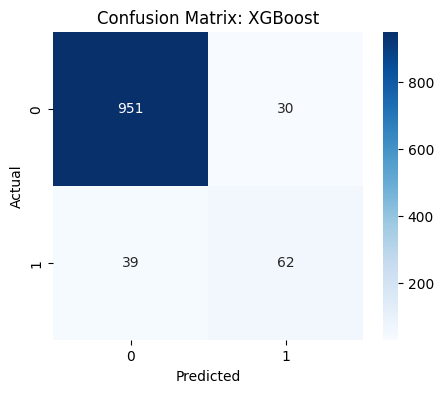

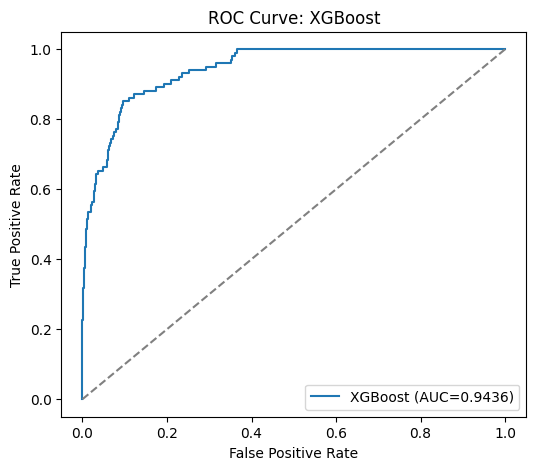

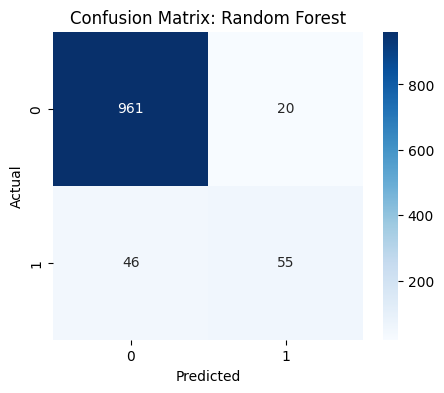

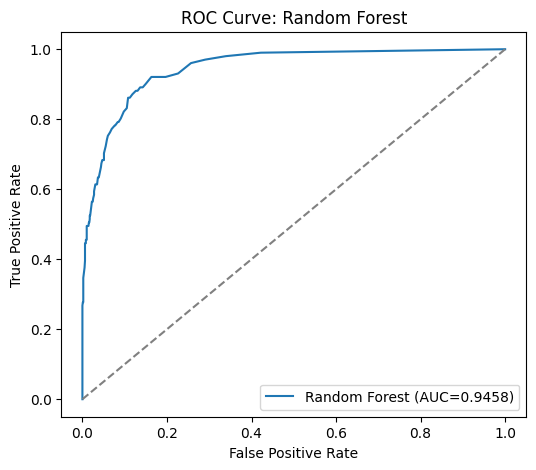

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


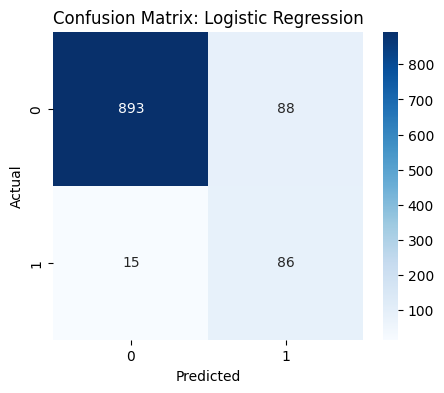

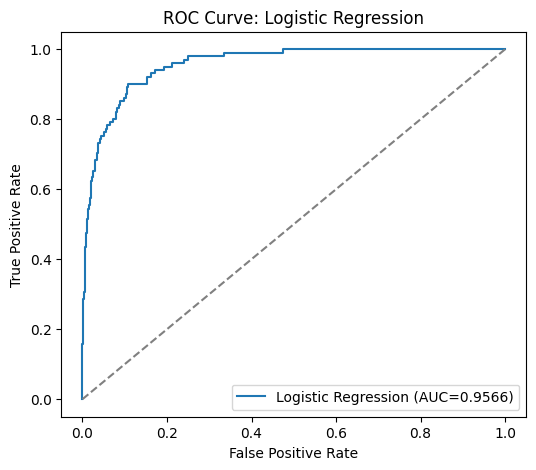

=== Model Comparison Summary ===


,Model,Precision,Recall,F1-score,PRAUC,ROC AUC
0,XGBoost,0.673913,0.613861,0.642487,0.728605,0.943602
1,Logistic Regression,0.494253,0.851485,0.625455,0.754719,0.956601
2,Random Forest,0.733333,0.544554,0.625000,0.737112,0.945767


In [22]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {classes[i]: weights[i] for i in range(len(classes))}

#Initialize models
models = {
    'XGBoost': xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=class_weight_dict[1],  # positive class weight
        random_state=42,
        n_estimators=300,
        max_depth=7,
        learning_rate=0.2
    ),
    'Random Forest': RandomForestClassifier(
        class_weight=class_weight_dict,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        class_weight=class_weight_dict,
        random_state=42
    )
}


#Train models and evaluate metrics
results_summary = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    # Metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # PRAUC
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
    prauc = auc(recall_curve, precision_curve)

    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_proba)

    results_summary.append({
        'Model': name,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'PRAUC': prauc,
        'ROC AUC': roc_auc
    })

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.4f})')
    plt.plot([0,1], [0,1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {name}')
    plt.legend()
    plt.show()

# Compare all models in a DataFrame
results_df = pd.DataFrame(results_summary)
results_df = results_df.sort_values(by='F1-score', ascending=False).reset_index(drop=True)
print("=== Model Comparison Summary ===")
results_df